# Data Preprocessing

In this part we will prepare our data to model building. Here we explore what components we should change, but working code, which we could use in our work I will post with another file, where you can find pipeline of work from getting data to model.

In [135]:
#importing main data analysis libraries  
import pandas as pd 
import numpy as np
#importing main visualization libraries
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

%matplotlib inline 

#set visualization settings
large = 30; med = 14; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (13, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")

In [136]:
train = pd.read_csv('C:/Users/user/Projects/Health_Insurance_Sell_Analysis/data/train.csv')

## Encoding features
Firstly, we should encode our data, because we will calculate by Random Forest, which our features are important, and this algorithm is working only with encode data

In [139]:
#But we should rename our columns for easier working with it
for column in train.columns:
    column_lower = column.lower()
    train = train.rename(columns = {column:column_lower})

In [137]:
#this func encode our features, we could use OneHotEncoder, but we need strict values, which we need
def encoder(x):
    if x== 'Male' or x == 'No' or x == '< 1 Year':
        return int(0)
    elif x== 'Male' or x == 'Yes' or x == '1-2 Year':
        return int(1)
    else:
        return int(2)

In [140]:
names = ['gender', 'vehicle_age', 'vehicle_damage']
features = [train.gender, train.vehicle_age, train.vehicle_damage]
for feature in features:
    for name in names:
        train[name] = feature.apply(encoder)

In [141]:
train.policy_sales_channel = train.policy_sales_channel.apply(lambda x: int(x))

In [142]:
train.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,1,44,1,28.0,0,1,1,40454.0,26,217,1
1,2,0,76,1,3.0,0,0,0,33536.0,26,183,0
2,3,1,47,1,28.0,0,1,1,38294.0,26,27,1
3,4,0,21,1,11.0,1,0,0,28619.0,152,203,0
4,5,0,29,1,41.0,1,0,0,27496.0,152,39,0


## Dropping features

In [143]:
train = train.drop(columns= ['id', 'region_code'], axis = 1)

In [144]:
train.columns

Index(['gender', 'age', 'driving_license', 'previously_insured', 'vehicle_age',
       'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage',
       'response'],
      dtype='object')

### Find not important features using Random Forest

In [79]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    train.drop(columns= 'response', axis = 1), 
    train['response'], 
    test_size=0.2,
    random_state = 42)

In [80]:
from sklearn.ensemble import RandomForestClassifier

rfc_ftrs = RandomForestClassifier()

rfc_ftrs.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [82]:
df_ftrs = pd.DataFrame({
    'features':X_train.columns,
    'importance':rfc_ftrs.feature_importances_
})

df_ftrs

#as we can see gender and driving license doesn't make a big sense in our dataset, so we can drop them
#we could drop previously insured, vehicle_age and etc. as well, but it can make our data too small and our models
#would be underfitted

,features,importance
0,id,0.211183
1,gender,0.012660
2,age,0.121872
3,driving_license,0.000502
4,region_code,0.086872
5,previously_insured,0.057700
6,vehicle_age,0.018765
7,vehicle_damage,0.069356
8,annual_premium,0.172413
9,policy_sales_channel,0.056777


In [145]:
train = train.drop(columns = ['gender', 'driving_license'], axis = 1)

## Remove outliers
Here we will remove outliers to make our models work more efficient. In EDA part we saw, that annual_premium had a lot of outliers, which we should remove.

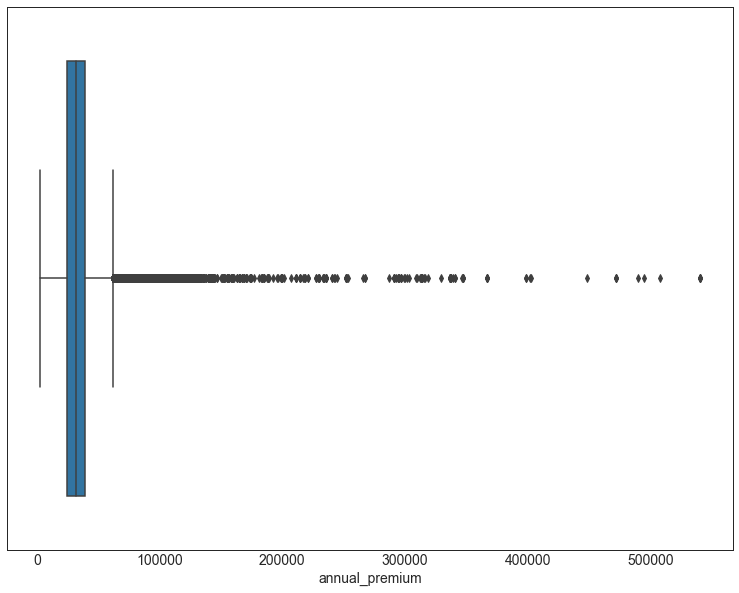

In [146]:
##if we look on first boxplot, we can see a lot of outliers, they started after 60000
ap_boxplot_bf = plt.subplot()
ap_boxplot_bf = sns.boxplot(
    x = 'annual_premium',
    data = train
)
plt.show()

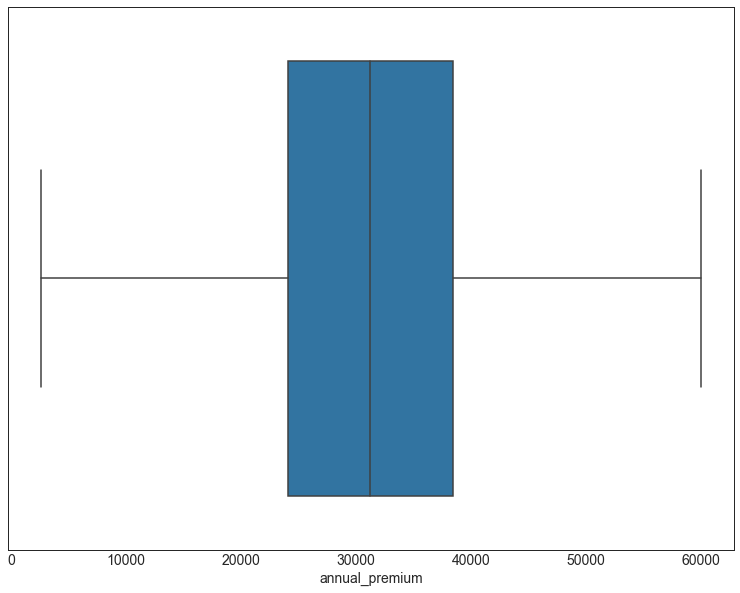

In [147]:
#if we limit it we got normal boxplot, without big outliers, lets check how much do we lost
sns.boxplot(
    x = train[train.annual_premium <= 60000].annual_premium,
    data = train
)

In [148]:
#we didn't lost too much, only 13 000 rows, in my opinion it would improve work of our model, so we can continue with this
print(train.shape,'\n',
      train[train.annual_premium <= 60000].shape)

(381109, 8) 
 (368950, 8)


In [149]:
train = train[train.annual_premium <= 60000]

## Feature Scaling
Here we will scale our data with MinMaxScaler, because we need this type of data to improve work with SVC and other algorithms. 

In [151]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()


train[['annual_premium', 'vintage', 'age']] = scaler.fit_transform(train[['annual_premium', 'vintage', 'age']])

In [152]:
train.head()

,age,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,0.369231,0,1,1,0.659299,26,0.716263,1
1,0.861538,0,0,0,0.538714,26,0.598616,0
2,0.415385,0,1,1,0.621649,26,0.058824,1
3,0.015385,1,0,0,0.453007,152,0.667820,0
4,0.138462,1,0,0,0.433432,152,0.100346,0


## Prepared data output
Here we will output our data to another file.

In [153]:
train.to_csv('prepared_data', index= False)